# PCA
This notebook can be used to do PCA on the following things:
- Sound speed and equation of state of the dark sector in the 2-fluid model
- Sound speed and equation of state of dark matter and neutrinos in the 3-fluid model
- Standard cosmological parameters in the 3-fluid model


In [36]:
# third party imports
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import numba
import pickle

# other project files
import modes
import spectra

In [37]:
# numerical parameters
NT = 2**13
NK = 2**11
NX = 10000
L_MAX = 2500
xmin = 0.01
xmax = 3000
a0 = 1.e-6
a0_pca = 5.e-5
a_rec = 1/1100

# arrays
A = np.linspace(a0, a_rec, 2*NT)
K = np.linspace(.1, 800, NK)
L = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, L_MAX+1, 20)])
L_eval = np.arange(2, L_MAX+1)
NL = len(L)
X = np.linspace(xmin, xmax, NX)
JLX, DJLX = spectra.get_bessels(L, X)

Bessel functions loaded from file.


# 3-fluid  model
The function params_PCA below gets the fisher matrix for the scalar-valued parameters in the 3-fluid model. Equation of state and sound speed for CDM and neutrinos are treated as scalar parameters (they aren't allowed to depend on time or wavenumber).

In [38]:
# physical parameters
h = 0.6774
As = np.exp(3.064)/1.e10 # scalar perturbation amplitude
TCMB0 = 2.72548 * 1.e6 # CMB temp (microK)
OmegaM0 = 0.3089
OmegaB0 = 0.0486
OmegaR0 = 4.2e-5/h**2
OmegaN0 = OmegaR0*(1-1/1.68)
OmegaG0 = OmegaR0 - OmegaN0
OmegaC0 = OmegaM0 - OmegaB0
wC = np.zeros(2*NT)
wN = np.ones(2*NT)*1/3
cs2C = np.zeros((2*NT, NK))
cs2N = np.ones((2*NT, NK))*1/3
params_F = [wC, cs2C, wN, cs2N, OmegaB0, OmegaC0, OmegaG0, OmegaN0, As, TCMB0, h]

Cl = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_F)
err = spectra.get_Cl_err(L_eval,Cl)
Sigma = np.diag(err**2)

def params_PCA(t):
    """Fisher matrix for density parameters, equation of state, sound speed."""

    NC = len(params_F) #number of parameters
    ss = 0.1**t #(derivative step size)
    B = np.eye(NC)
    J = np.zeros((len(L_eval), NC))

    print('computing derivatives (t='+str(t)+')')
    # take the central-difference derivatives with respect to each parameter
    for n in range(NC):
        params_fwd = params_F + ss*B[n]
        params_bwd = params_F - ss*B[n]
        Cl_fwd = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_fwd)
        Cl_bwd = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_bwd)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
            
    # save the derivatives
    pickle.dump(J, open("output/params/J_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (t='+str(t)+')')
    
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/params/F_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (t='+str(t)+')')
    
params_PCA(7)

computing derivatives (t=7)

 derivatives saved (t=7)

 Fisher matrix saved (t=7)


#  2-fluid model
Below are functions to do PCA on the equation of state and the sound speed of the dark sector in the two fluid model

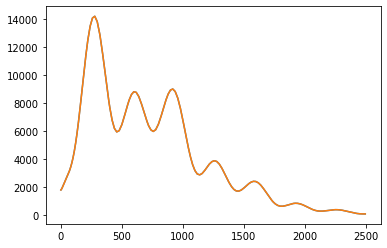

In [39]:
"""Get the fiduciary parameters for the 2-fluid model"""

# solve for perturbation history using 3-fluid model.
Y, TAU = modes.solve_3fld(A, K, wC, cs2C, wN, cs2N, OmegaB0, OmegaC0,
           OmegaG0, OmegaN0)

Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC =Y[:, 3, :].T
vC = Y[:, 4, :].T
deltaN = Y[:, 5, :].T
vN =Y[:, 6, :].T

OmegaB = OmegaB0 * A[::2]**-3
OmegaC = OmegaC0 * A[::2]**-3
OmegaN = OmegaN0 * A[::2]**-4
OmegaG = OmegaG0 * A[::2]**-4
OmegaD = OmegaN + OmegaC

# calculate GDM functions
wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN/3)/(deltaD*OmegaD)
delta_pD = deltaN

deltaD, vD, cs2D, delta_pD = deltaD.T, vD.T, cs2D.T, delta_pD.T

Cl2 = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
plt.plot(Cl)
plt.plot(Cl2)

In [40]:
"""Helper functions for cs2 PCA"""

@numba.njit
def square_basis(theta, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < a0_pca]=0
    return out.T

def get_square(n, val, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    r,c = n//NC, n%NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < a0_pca]=0
    return out.T

In [41]:
def W_PCA(q, t, a0):
    """This function does PCA on the equation of state in the 2-fluid model, with the sound speed fixed to the fiduciary.
    q determines the basis size, and t determines the derivative step size. a0 is the 'cutoff time', before
    which the equation of state is not varied during PCA. The outputs (derivatives, fisher matrix, PCs, and singular values)
    are saved to pickle files formatted like 'output/w-only/J_q-[q]_t-[t].p'. So, for example, if you make the function call
    W_PCA(q=7,t=7,a0=1.e-5), the following files will be created:
    output/w-only/J_q-7_t-5.p,  output/w-only/F_q-7_t-5.p,   output/w-only/PC_q-7_t-5.p,   output/w-only/SV_q-7_t-5.p.
    These respectively store the derivatives, the fisher matrix, the principal components, and the singular values.
    """
    
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # initialize a 1-d gaussian basis
    B = np.zeros((NC,NT))
    width=NT//(NC-1)
    for i in range(NC):
        # each row of B is a gaussian basis-element
        if A[::2][i*width]>a0_pca:
            B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)
       
        #B[i,A[::2] < a0_pca]=0
    # initialize an empty array to hold the partial derivatives
    J = np.zeros((len(L_eval), NC))
    print('computing derivatives (q='+str(q)+',t='+str(t)+')')
    for n in range(NC):
        # Take the central-difference derivative of Cl with respect to the nth basis coefficient.
        Delta_w = ss*B[n]
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD+Delta_w, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD-Delta_w, cs2D,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        # The result goes in the nth column of J.
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
    
    # save the derivatives
    pickle.dump(J, open("output/w-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the  Fisher matrix.
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/w-only/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the singular values and principal components.
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, NT))
    for i in range(10):
        PC[i,:] = PV[:,i]@B
    pickle.dump(PC, open("output/w-only/PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/w-only/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (q='+str(q)+',t='+str(t)+')')

In [42]:
def CS2_PCA(q, t, a0):
    """This function does PCA on the sound speed in the 2-fluid model, with the equation of state fixed to the fiduciary.
    q determines the basis size, and t determines the derivative step size. a0 is the 'cutoff time', before
    which the sound speed is not varied during PCA. The outputs (derivatives, fisher matrix, PCs, and singular values)
    are saved to pickle files formatted like 'output/cs2-only/J_q-[q]_t-[t].p'. So, for example, if you make the function call
    W_PCA(q=7,t=7,a0=1.e-5), the following files will be created:
    output/cs2-only/J_q-7_t-5.p,  output/cs2-only/F_q-7_t-5.p,   output/cs2-only/PC_q-7_t-5.p,   output/cs2-only/SV_q-7_t-5.p.
    These respectively store the derivatives, the fisher matrix, the principal components, and the singular values.
    """
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size
    
    # take the central-difference derivatives of Cl w.r.t. cs2 basis coefficients.
    J = np.zeros((len(L_eval), NC**2))
    print('computing derivatives (t='+str(t)+')')
    for n in range(NC**2):
        delta_cs2 = get_square(n, ss, NC)
        Cl_fwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D+delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        Cl_bwd = spectra.get_Cl_2fld(L, L_eval, X, JLX, DJLX, A[::2], K, wD, cs2D-delta_cs2,
                                     deltaD[0], vD[0], OmegaB0, OmegaC0, OmegaG0, OmegaN0,
                                     As, TCMB0, h)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 10 == 0):
            print(str(n) + ' of ' + str(NC**2))
    
    # save the derivatives
    pickle.dump(J, open("output/cs2-only/J_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','derivatives saved (q='+str(q)+',t='+str(t)+')')
    
    # compute and save the  Fisher matrix.
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/cs2-only/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','Fisher matrix saved (q='+str(q)+',t='+str(t)+')')
    
    print('\n','computing PCs (t='+str(t)+')')
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 
    PC = np.zeros((10, NT, NK))
    for i in range(10):
        PC[i,:,:] = square_basis(PV[:,i], NC)
    pickle.dump(PC, open("output/cs2-only/PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/cs2-only/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (q='+str(q)+',t='+str(t)+')')

In [43]:
def W_CS2_PCA(q, t, a0):
    NC = 2**q # number of basis elements
    ss = 0.1**t # derivative step size

    # initialize a 1-d gaussian basis
    B = np.zeros((NC,NT))
    width=NT//(NC-1)
    for i in range(NC):
        # each row of B is a gaussian basis-element
        if A[::2][i*width]>a0_pca:
            B[i] = np.exp(-(np.arange(NT) - i*width)**2 / (width)**2)

    J_w = pickle.load(open("output/w-only/J_q-"+str(q)+"_t-"+str(t)+".p", "rb"))
    J_cs2 = pickle.load(open("output/cs2-only/J_q-"+str(q)+"_t-"+str(t)+".p", "rb"))
    J = np.concatenate((J_w,J_cs2),axis=1)

    # compute and save the  Fisher matrix.
    F = J.T@np.linalg.inv(Sigma)@J
    pickle.dump(F, open("output/w-cs2/F_q-"+str(q)+"_t-"+str(t)+".p", "wb"))

    print('\n','computing PCs (t='+str(t)+')')
    u, s, v = np.linalg.svd(F)
    PV = np.real(u) 

    PV_w = PV[:NC,:]
    PV_cs2 = PV[NC:,:]
    print(np.shape(PV_w))

    PC_w = np.zeros((10, NT))
    PC_cs2 = np.zeros((10, NT, NK))
    for i in range(10):
        PC_w[i,:] = PV_w[:,i]@B
        PC_cs2[i,:,:] = square_basis(PV_cs2[:,i], NC)
    pickle.dump(PC_w, open("output/w-cs2/wPC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(PC_cs2, open("output/w-cs2/cs2PC_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    pickle.dump(s, open("output/w-cs2/SV_q-"+str(q)+"_t-"+str(t)+".p", "wb"))
    print('\n','PCs and SVs saved (q='+str(q)+',t='+str(t)+')')

In [44]:
CS2_PCA(q=4,t=7,a0=a0_pca)
CS2_PCA(q=5,t=7,a0=a0_pca)
CS2_PCA(q=6,t=7,a0=a0_pca)

computing derivatives (t=7)
0 of 256
10 of 256
20 of 256
30 of 256
40 of 256
50 of 256
60 of 256
70 of 256
80 of 256
90 of 256
100 of 256
110 of 256
120 of 256
130 of 256
140 of 256
150 of 256
160 of 256
170 of 256
180 of 256
190 of 256
200 of 256
210 of 256
220 of 256
230 of 256
240 of 256
250 of 256

 derivatives saved (q=4,t=7)

 Fisher matrix saved (q=4,t=7)

 computing PCs (t=7)

 PCs and SVs saved (q=4,t=7)
computing derivatives (t=7)
0 of 1024
10 of 1024
20 of 1024
30 of 1024
40 of 1024
50 of 1024
60 of 1024
70 of 1024
80 of 1024
90 of 1024
100 of 1024
110 of 1024
120 of 1024
130 of 1024
140 of 1024
150 of 1024
160 of 1024
170 of 1024
180 of 1024
190 of 1024
200 of 1024
210 of 1024
220 of 1024
230 of 1024
240 of 1024
250 of 1024
260 of 1024
270 of 1024
280 of 1024
290 of 1024
300 of 1024
310 of 1024
320 of 1024
330 of 1024
340 of 1024
350 of 1024
360 of 1024
370 of 1024
380 of 1024
390 of 1024
400 of 1024
410 of 1024
420 of 1024
430 of 1024
440 of 1024
450 of 1024
460 of 1024
47

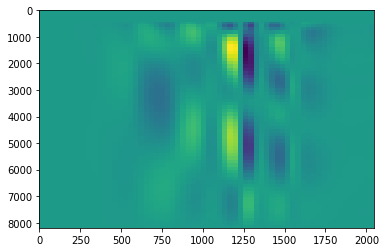

In [51]:
cPC = pickle.load(open("output/cs2-only/PC_q-6_t-7.p", "rb"))
plt.imshow(cPC[4],aspect='auto')

In [52]:
# this takes a long time...
W_PCA(q=4, t=7, a0=a0_pca)
W_PCA(q=5, t=7, a0=a0_pca)
W_PCA(q=6, t=7, a0=a0_pca)
W_PCA(q=7, t=7, a0=a0_pca)
CS2_PCA(q=4, t=7, a0=a0_pca)
CS2_PCA(q=5, t=7, a0=a0_pca)
CS2_PCA(q=6, t=7, a0=a0_pca)
CS2_PCA(q=7, t=7, a0=a0_pca)
W_CS2_PCA(q=4, t=7, a0=a0_pca)
W_CS2_PCA(q=5, t=7, a0=a0_pca)
W_CS2_PCA(q=6, t=7, a0=a0_pca)
W_CS2_PCA(q=7, t=7, a0=a0_pca)

computing derivatives (q=4,t=7)

 derivatives saved (q=4,t=7)

 Fisher matrix saved (q=4,t=7)

 PCs and SVs saved (q=4,t=7)
computing derivatives (q=5,t=7)

 derivatives saved (q=5,t=7)

 Fisher matrix saved (q=5,t=7)

 PCs and SVs saved (q=5,t=7)
computing derivatives (q=6,t=7)

 derivatives saved (q=6,t=7)

 Fisher matrix saved (q=6,t=7)

 PCs and SVs saved (q=6,t=7)
computing derivatives (q=7,t=7)

 derivatives saved (q=7,t=7)

 Fisher matrix saved (q=7,t=7)

 PCs and SVs saved (q=7,t=7)
computing derivatives (t=7)
0 of 16384
10 of 16384
20 of 16384
30 of 16384
40 of 16384
50 of 16384
60 of 16384
70 of 16384
80 of 16384
90 of 16384
100 of 16384
110 of 16384
120 of 16384
130 of 16384
140 of 16384
150 of 16384
160 of 16384
170 of 16384
180 of 16384
190 of 16384
200 of 16384
210 of 16384
220 of 16384
230 of 16384
240 of 16384
250 of 16384
260 of 16384
270 of 16384
280 of 16384
290 of 16384
300 of 16384
310 of 16384
320 of 16384
330 of 16384
340 of 16384
350 of 16384
360 of 16384
370 of

5560 of 16384
5570 of 16384
5580 of 16384
5590 of 16384
5600 of 16384
5610 of 16384
5620 of 16384
5630 of 16384
5640 of 16384
5650 of 16384
5660 of 16384
5670 of 16384
5680 of 16384
5690 of 16384
5700 of 16384
5710 of 16384
5720 of 16384
5730 of 16384
5740 of 16384
5750 of 16384
5760 of 16384
5770 of 16384
5780 of 16384
5790 of 16384
5800 of 16384
5810 of 16384
5820 of 16384
5830 of 16384
5840 of 16384
5850 of 16384
5860 of 16384
5870 of 16384
5880 of 16384
5890 of 16384
5900 of 16384
5910 of 16384
5920 of 16384
5930 of 16384
5940 of 16384
5950 of 16384
5960 of 16384
5970 of 16384
5980 of 16384
5990 of 16384
6000 of 16384
6010 of 16384
6020 of 16384
6030 of 16384
6040 of 16384
6050 of 16384
6060 of 16384
6070 of 16384
6080 of 16384
6090 of 16384
6100 of 16384
6110 of 16384
6120 of 16384
6130 of 16384
6140 of 16384
6150 of 16384
6160 of 16384
6170 of 16384
6180 of 16384
6190 of 16384
6200 of 16384
6210 of 16384
6220 of 16384
6230 of 16384
6240 of 16384
6250 of 16384
6260 of 16384
6270 o

11320 of 16384
11330 of 16384
11340 of 16384
11350 of 16384
11360 of 16384
11370 of 16384
11380 of 16384
11390 of 16384
11400 of 16384
11410 of 16384
11420 of 16384
11430 of 16384
11440 of 16384
11450 of 16384
11460 of 16384
11470 of 16384
11480 of 16384
11490 of 16384
11500 of 16384
11510 of 16384
11520 of 16384
11530 of 16384
11540 of 16384
11550 of 16384
11560 of 16384
11570 of 16384
11580 of 16384
11590 of 16384
11600 of 16384
11610 of 16384
11620 of 16384
11630 of 16384
11640 of 16384
11650 of 16384
11660 of 16384
11670 of 16384
11680 of 16384
11690 of 16384
11700 of 16384
11710 of 16384
11720 of 16384
11730 of 16384
11740 of 16384
11750 of 16384
11760 of 16384
11770 of 16384
11780 of 16384
11790 of 16384
11800 of 16384
11810 of 16384
11820 of 16384
11830 of 16384
11840 of 16384
11850 of 16384
11860 of 16384
11870 of 16384
11880 of 16384
11890 of 16384
11900 of 16384
11910 of 16384
11920 of 16384
11930 of 16384
11940 of 16384
11950 of 16384
11960 of 16384
11970 of 16384
11980 of 1

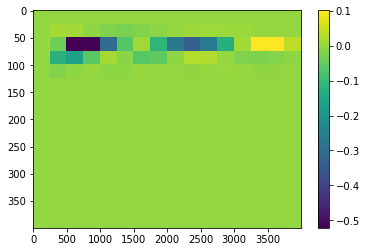

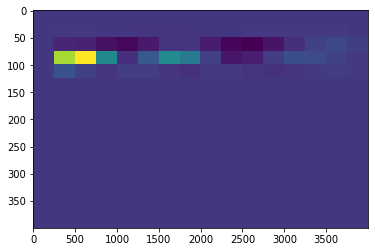

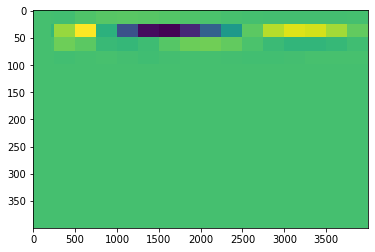

In [30]:
PC = pickle.load(open("output/cs2-only/PC_q-4_t-7.p", "rb"))
plt.imshow(PC[0].T,aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(PC[1].T,aspect='auto')
plt.show()
plt.imshow(PC[2].T,aspect='auto')